# Regressão Logística nos dados covtype de LIBSVM

Iremos treinar os dados para classificação binária usando os dados `covtype` da biblioteca [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). Veja também [Kaggle-LIBSVM](https://www.kaggle.com/code/tanmayunhale/libsvm-liblinear).

Queremos minimizar

$$
\min_{w\in {\mathbb R}^{d\times1}} f(w)=-\frac{1}{n}\sum_{i=1}^n \left(y_i \log (s(x_i^\top w)) + (1 - y_i) \log (1 - s(x_i^\top w))\right) + \frac{\gamma}{2}\|w\|^2,
$$

onde $x_i\in {\mathbb R}^{d\times1}$, $y_i\in \{0, 1\}$, $s(z)=\frac{1}{1+\exp(-z)}$ é a função sigmóide. O gradiente é dado por

$$
\nabla f(w) = \frac{1}{n}\sum_{i=1}^n x_i(s(x_i^\top w)-y_i) + \gamma w.
$$

Esta é uma função suave com constante de Lipschitz $L=L_0+\gamma$ onde

$$
L_0 = \frac{1}{4}\lambda_{\max}\left(\frac{X^\top X}{n}\right),
$$ 

onde $X\in\mathbb{R}^{n\times d}$ é a matriz de dados cuja $i$-ézima linha é o vetor $x_i^\top$ e $\lambda_{\max}(\cdot)$ denota o maior autovalor.

In [5]:
# Importação de módulos necesserários:

import matplotlib
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file
from sklearn.utils.extmath import safe_sparse_dot

In [6]:
# Lendo os dados do arquivo covtype e guardando na matriz de dados X e vetor de labels y:

data = load_svmlight_file('./datasets/covtype.bz2')
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Devemos garantir que os labels estão em {0, 1}
    y -= 1    
    
n, d = X.shape # tamanho da amostra, número de features    

# Exercício 1: Funções auxiliares

1. Construa uma função `smoothness(X)` que toma a matriz de dados `X` e retorna a constante $L_0$.
2. Construa uma função `f(w, X, y, l2)` que toma o iterado `w`, os dados `X, y` e a penalização $\gamma$ (=`l2`) e retorna o valor funcional $f(w)$.
3. Construa uma função `df(w, X, y, l2)` toma o iterado `w`, os dados `X, y` e a penalização $\gamma$ (=`l2`) e retorna o gradiente $\nabla f(w)$.

In [7]:
#Escreva código aqui
def smoothness(X):
    n = X.shape[0]
    XtX = (X.T @ X) / n
    lambda_max = la.eigvalsh(XtX).max()
    L0 = lambda_max / 4
    return L0

def f(w, X, y, l2):
    z = X @ w
    s = 1 / (1 + np.exp(-z))
    log_loss = -np.mean(y * np.log(s) + (1 - y) * np.log(1 - s))
    reg_term = (l2 / 2) * np.linalg.norm(w)**2
    return log_loss + reg_term

def df(w, X, y, l2):
    n = X.shape[0]
    z = X @ w
    s = 1 / (1 + np.exp(-z))
    grad = (1 / n) * X.T @ (s - y) + l2 * w
    return grad

# Inicialização

Fixaremos:

In [8]:
L0 = smoothness(X)
l2 = L0 / n
L = L0 + l2
w0 = np.zeros(d)        # ponto inicial
it_max = 10000          # número de iterações

#Função de desempenho é a norma de Frobenius:
J = lambda w: la.norm(w)

#Função que retorna gradiente (para X,y,l2) já declarados.
def Df(w):
    return df(w, X, y, l2)

l2

np.float64(8.676367672880712)

# Exercício 2: Método do gradiente

Construa uma função `gd(df, w0, la=1, numb_iter=100)` que toma como entrada as funções `J()` `df()`, o ponto inicial `w0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente iniciando de `w0`. Esta função deve retornar a sequência de valores da função $\Vert\nabla f(w)\Vert_2$ em cada um dos iterados $w$. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L` 

In [9]:
#Escreva código aqui
def gd(J, df, w0, la=1, numb_iter=100):
    w = w0
    grad_norms = list()
    step_size = 1 / la

    for i in range(numb_iter):
        grad = df(w)
        grad_norm = J(grad)
        grad_norms.append(grad_norm)
        
        w -= step_size * grad

    return grad_norms, w

In [10]:
# gradient descent
f1 = gd(J, Df, w0, la=1./L, numb_iter=it_max)

/tmp/ipykernel_42275/65709351.py:19: RuntimeWarning: overflow encountered in exp
  s = 1 / (1 + np.exp(-z))
/tmp/ipykernel_42275/65709351.py:18: RuntimeWarning: overflow encountered in matmul
  z = X @ w
/tmp/ipykernel_42275/65709351.py:18: RuntimeWarning: invalid value encountered in matmul
  z = X @ w


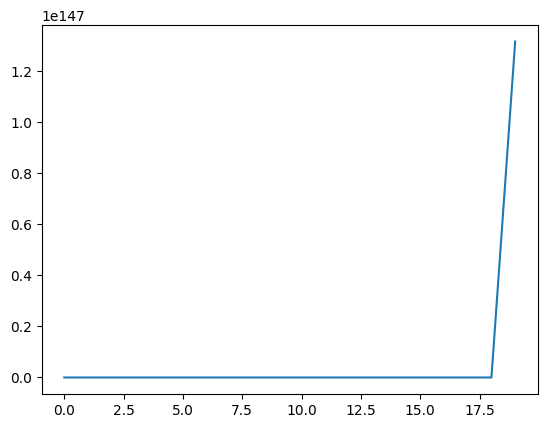

In [11]:
plt.plot(f1[0])

# Exercício 3: Método do gradiente acelerado

Construa uma função `accel_gd(J, df, w0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df()`, o ponto inicial `w0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `w0` e $t_0=1$:
\begin{align*}
w_{k+1}&:= y_k - la\nabla f(y_k),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
y_{k+1} &:= w_{k+1} + \frac{t_{k}-1}{t_{k+1}}(w_{k+1}-w_{k}).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L`.

In [19]:
#Escreva código aqui

Time execution for accelerated AGD: 842.4450372909196


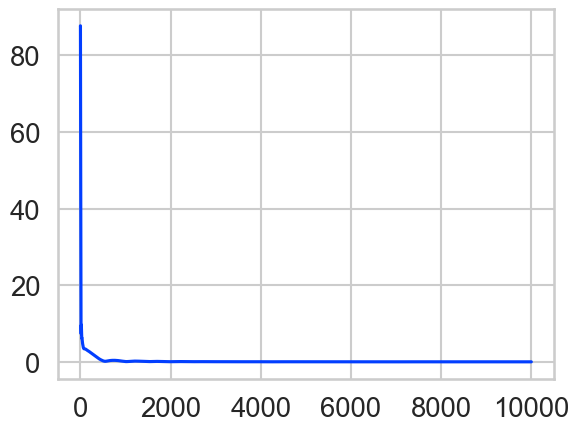

In [20]:
# Nesterov accelerated gradient descent
f2 = accel_gd(J, Df, w0, la=1./L, numb_iter=it_max)
plt.plot(f2[0])

# Exercício 4: Método do gradiente acelerado com $\gamma$

Construa uma função `accel_gd_sc(J, df, w0, la=1, kappa, numb_iter=100)` que toma como entrada as funções `J()`, `df()`, o ponto inicial `w0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `y0=w0`:
\begin{align*}
w_{k+1}&:= y_k - la\nabla f(y_k),\\
y_{k+1} &:= w_{k+1} + \frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}(w_{k+1}-w_{k}).
\end{align*}
Àcima, $\kappa:=L/\gamma$. Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L`.

In [21]:
#Escreva código aqui

Time execution for accelerated AGD-SC: 818.4171042499365


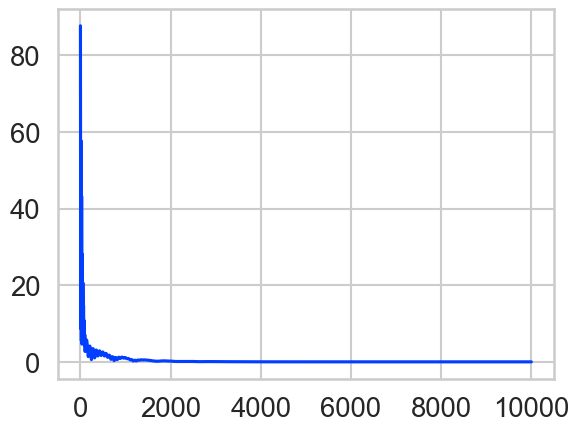

In [22]:
# Nesterov accelerated gradient descent for strongly convex functions
f3 = accel_gd_sc(J, Df, w0, la=1./L, kappa=L/l2, numb_iter=it_max)
plt.plot(f3[0])

# Exercício 5: Adagrad-Norm

Construa uma função `ad_grad_norm(J, Df, w0, b0=0.5, eta=1, numb_iter=100)` que toma como entrada as funções `J()`, `Df`, o ponto inicial `w0`, parametros positivos `b0` e `eta` e o número de iterações `numb_iter` e implementa o método Adagrad-Norm iniciando de `w0`:
\begin{align*}
w_{k+1}&:= w_k - \frac{\eta}{\sqrt{b_0^2 + \sum_{j=1}^k\Vert\nabla f(w_j)\Vert_2^2}} \nabla f(w_k).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(Df(w))` em cada um dos iterados `w`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `b0=0.5` e `eta=1`.

In [23]:
#Escreva código aqui

Time execution for GD: 1487.6604519160464


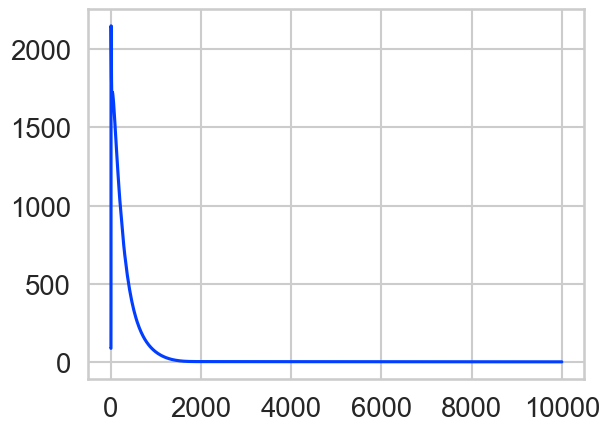

In [24]:
# Adagrad-Norm
f4 = ad_grad_norm(J, Df, w0, b0=0.5, eta=0.01, numb_iter=it_max)
plt.plot(f4[0])

# Exercício 6: Adam

Construa uma função `adam(Df, w0, alpha, beta1, beta2, epsilon, numb_iter)` que toma como entrada as funções `Df`, o ponto inicial `w0`, parametros positivos `alpha`, `beta1`, `beta2`, `epsilon` e o número de iterações `numb_iter` e implementa o método Adam iniciando de `w0`, $m_0=0$, $v_0=0$ e $k=0$: para cada $j$ézima coordenada:
\begin{align*}
m_{k+1}[j] &:= \beta_1\cdot m_{k}[j] + (1-\beta_1)\cdot\nabla f(w_k)[j],\\
v_{k+1}[j] &:= \beta_2\cdot v_{k}[j] + (1-\beta_2)\cdot(\nabla f(w_k)[j])^2,\\
\hat m_{k+1}[j] &:= \frac{1}{1-\beta_1^{k+1}}m_{k+1}[j],\\
\hat v_{k+1}[j] &:= \frac{1}{1-\beta_2^{k+1}}v_{k+1}[j],\\
w_{k+1}[j] &:= w_{k}[j] - \frac{\alpha}{\sqrt{\hat v_{k+1}[j]} + \epsilon }\hat m_{k+1}[j].
\end{align*}
Esta função deve retornar a sequência de valores da função `J(Df(w))` em cada um dos iterados `w`, isto é, a sequência das normas dos gradientes de $w_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `alpha=0.001`, `beta1=0.9`, `beta2=0.999`, `epsilon=10**(-8)`. 

In [13]:
#Escreva código aqui

Time execution for Adam: 2356.390969166998


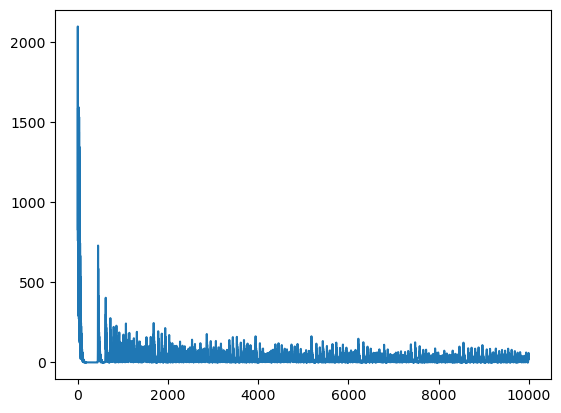

In [14]:
# Adam
f5 = adam(Df, w0, alpha=0.01, beta1=0.9, beta2=0.99, epsilon=10**(-8), numb_iter=it_max)
plt.plot(f5[0])

# Exercício 7: 

Implemente num mesmo gráfico os erros $\Vert\nabla f(w_k)\Vert$ de cada método em função no número de iterações.

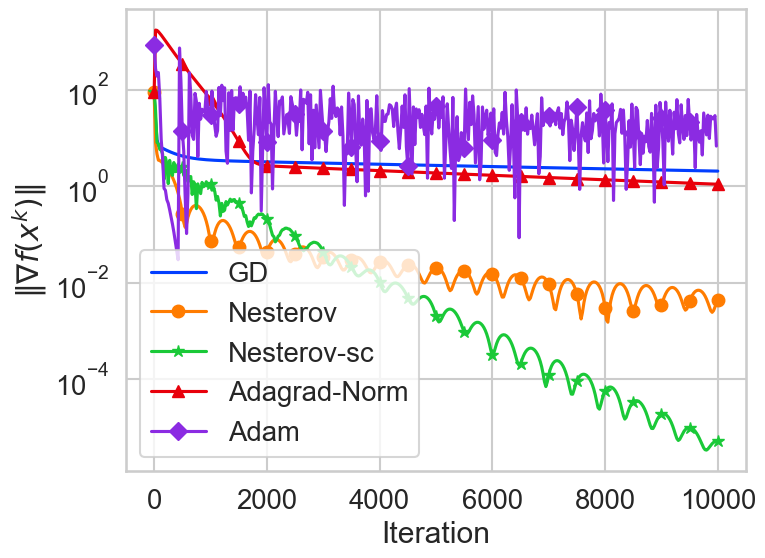

In [25]:
#Escreva código aqui

# Exercício 8:

Experimente com os hyper-parâmetros de Adagrad-Norm and Adam para ver se eles podem chegar perto ou superar a performance de GD e Nesterov. Plote o gráfico como no Exercício 7. 